In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf
import time

In [42]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [43]:
# Fungsi untuk membuat model LSTM atau BiLSTM
def create_model(input_shape, model_type='bilstm'):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if model_type == 'bilstm':
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Bidirectional(LSTM(64)))
    else:
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Fungsi untuk membuat dataset dengan timestep
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Fungsi untuk evaluasi kromosom
def evaluate_chromosome(chromosome, X_train, y_train, X_test, y_test, timesteps, model_type='bilstm'):
    selected_features = [i for i in range(len(chromosome)) if chromosome[i] == 1]
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    X_train_t, y_train_t = create_dataset(X_train_selected, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test_selected, y_test, timesteps)

    model = create_model((X_train_t.shape[1], X_train_t.shape[2]), model_type)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

    model.fit(X_train_t, y_train_t, epochs=10, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    y_pred = model.predict(X_test_t)
    mse = mean_squared_error(y_test_t, y_pred)
    mae = mean_absolute_error(y_test_t, y_pred)
    r2 = r2_score(y_test_t, y_pred)
    mape = mean_absolute_percentage_error(y_test_t, y_pred)

    print(f"Evaluating chromosome {chromosome} -> MSE: {mse}, MAE: {mae}, R²: {r2}, MAPE: {mape}")
    return mse

# Fungsi untuk inisialisasi populasi
def initialize_population(pop_size, num_features):
    population = [np.random.randint(2, size=num_features) for _ in range(pop_size - 1)]
    # Tambahkan satu kromosom yang memiliki semua fitur diaktifkan
    population.append(np.ones(num_features, dtype=int))
    print(f"Initialized population: {population}")
    return population

# Fungsi untuk seleksi
def select(population, fitnesses, num_parents):
    indices = np.argsort(fitnesses)[:num_parents]
    parents = [population[i] for i in indices]
    print(f"Selected parents: {parents}")
    return parents

# Fungsi untuk crossover
def crossover(parents, offspring_size):
    offspring = []
    for _ in range(offspring_size):
        parent1, parent2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, len(parent1)-1)
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring.append(child)
        print(f"Crossover between {parent1} and {parent2} at {crossover_point} -> {child}")
    return offspring

# Fungsi untuk mutasi
def mutate(offspring, mutation_rate):
    for child in offspring:
        if random.random() < mutation_rate:
            mutation_point = random.randint(0, len(child)-1)
            child[mutation_point] = 1 - child[mutation_point]
            print(f"Mutated child {child} at {mutation_point}")
    return offspring

# Main GA function
def genetic_algorithm(X, y, timesteps_list, pop_size=5, num_generations=2, mutation_rate=0.1):
    num_features = X.shape[1]
    best_chromosomes = {}
    total_start_time = time.time()

    for timesteps in timesteps_list:
        print(f"\nRunning GA for feature selection with timesteps = {timesteps}")
        population = initialize_population(pop_size, num_features)
        start_time = time.time()

        for generation in range(num_generations):
            generation_start_time = time.time()
            fitnesses = np.array([evaluate_chromosome(chrom, X, y, X, y, timesteps) for chrom in population])
            best_fitness = np.min(fitnesses)
            best_chromosome = population[np.argmin(fitnesses)]

            parents = select(population, fitnesses, pop_size//2)
            offspring = crossover(parents, pop_size - len(parents))
            offspring = mutate(offspring, mutation_rate)
            population = np.concatenate((parents, offspring))

            generation_end_time = time.time()
            print(f"Generation {generation}: Best Fitness = {best_fitness}")
            print(f"Best Chromosome: {best_chromosome}")
            print(f"Population: {population}")
            print(f"Execution time for generation {generation}: {generation_end_time - generation_start_time:.2f} seconds")

        end_time = time.time()
        best_chromosomes[timesteps] = best_chromosome
        print(f"Best Features for timesteps = {timesteps}: {best_chromosome}")
        print(f"Execution time for timesteps {timesteps}: {end_time - start_time:.2f} seconds")

    total_end_time = time.time()
    print(f"Total execution time for GA: {total_end_time - total_start_time:.2f} seconds")

    return best_chromosomes

In [44]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/aa_442300170322_engineered.csv')
# df
# df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
# df.drop('READ_DATE_day', axis=1, inplace=True)
df

,READ_DATE,KWH_EXP,tavg,tmin,tmax,wdir,wspd,pres,Tavg,RH_avg,RR,ss,KWH_EXP_MA,KWH_EXP_ES,trend_ma,cycle_ma
0,2019-01-01,11.001903,25.7,24.8,30.2,44.0,6.4,1008.9,25.7,96.0,12.9,7.5,11.353501,10.727112,21.551561,-10.198060
1,2019-01-02,11.422662,26.0,24.1,29.2,21.0,5.4,1009.2,25.9,90.0,42.7,6.7,11.353501,11.692460,21.558516,-10.205016
2,2019-01-03,2.341671,24.6,24.0,27.3,340.0,4.1,1010.3,24.9,94.0,0.5,0.1,11.353501,9.640836,21.565472,-10.211971
3,2019-01-04,4.800008,26.2,23.0,29.8,340.0,6.9,1011.4,25.8,88.0,34.6,0.1,11.353501,5.073890,21.572427,-10.218927
4,2019-01-05,5.752651,26.9,23.6,30.2,284.0,6.3,1011.7,26.7,88.0,2.1,3.2,11.353501,4.003960,21.579383,-10.225882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,2024-05-27,2.381903,28.3,24.4,34.0,126.0,9.9,1009.9,28.7,73.0,0.0,10.4,30.750679,1.889256,33.642867,-2.892188
1974,2024-05-28,2.412923,28.2,24.1,33.9,125.0,8.0,1009.4,28.2,75.0,0.0,8.2,28.331286,3.427209,33.650026,-5.318740
1975,2024-05-29,2.564494,29.0,24.2,33.0,130.0,7.7,1009.1,29.0,77.0,0.0,10.7,25.749157,2.469251,33.657186,-7.908029
1976,2024-05-30,2.558021,29.7,25.0,35.0,106.0,7.8,1009.7,29.6,73.0,0.0,10.6,23.339417,0.867502,33.664345,-10.324929


In [45]:
# # Menghitung nilai lambda untuk data harian berdasarkan aturan skala dari Ravn & Uhlig (2002)
# # Rumus umum:
# # lambda_new = lambda_base * (f_new / f_base) ** 4
# # Di mana:
# # - lambda_base = 1600 (untuk data kuartalan)
# # - f_base = 4 (frekuensi data kuartalan: 4 titik per tahun)
# # - f_new = 252 (jika hanya hari kerja) atau 365 (jika termasuk semua hari)

# # Perhitungan lambda untuk data harian (semua hari, 365 hari/tahun)
# lambda_daily_365 = 1600 * (365 / 4) ** 4  # Hasil: sekitar 69.3 x 10^9
# print(lambda_daily_365)
# # decompose menggunakan hpfilter
# cycle, trend = hpfilter(df['KWH_EXP_ES'], lamb=lambda_daily_365)
# df['trend_es'] = trend
# df['cycle_es'] = cycle

# # plot perbedaan data KWH_EXP dengan trend, KWH_EXP dengan cycle
# fig, ax = plt.subplots(2, 1, figsize=(12, 8))
# ax[0].plot(df['READ_DATE'], df['KWH_EXP_ES'], label='KWH_EXP_ES')
# ax[0].plot(df['READ_DATE'], df['trend_es'], label='Trend')
# ax[0].legend()

# ax[1].plot(df['READ_DATE'], df['KWH_EXP_ES'], label='KWH_EXP_ES')
# ax[1].plot(df['READ_DATE'], df['cycle_es'], label='Cycle')
# ax[1].legend()

# plt.show()


In [46]:
df.columns

Index(['READ_DATE', 'KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres',
       'Tavg', 'RH_avg', 'RR', 'ss', 'KWH_EXP_MA', 'KWH_EXP_ES', 'trend_ma',
       'cycle_ma'],
      dtype='object')

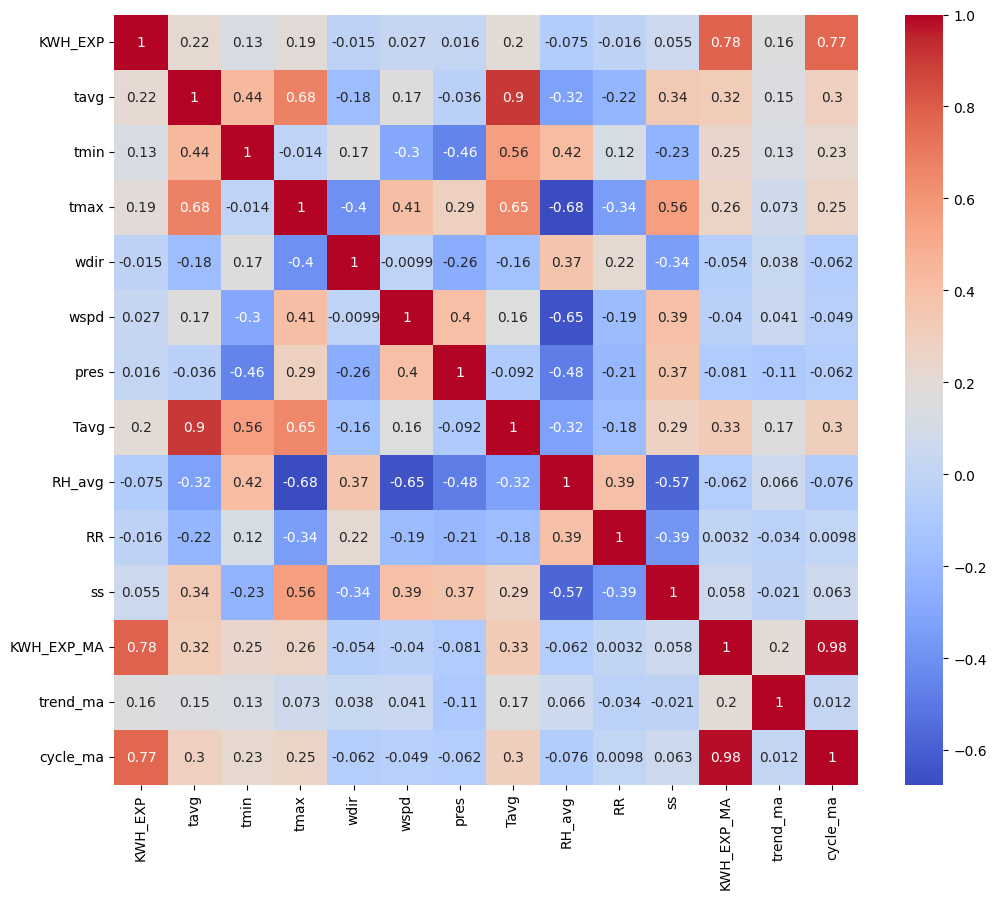

In [47]:
import seaborn as sns

# correlation plot
corr = df.copy()
# corr.drop(['READ_DATE', 'KWH_EXP_MA', 'trend_ma', 'cycle_ma'], axis=1, inplace=True)
corr.drop(['READ_DATE', 'KWH_EXP_ES'], axis=1, inplace=True)
corr = corr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [48]:
df.set_index('READ_DATE', inplace=True)

# set es or ma pred

# df.drop(['KWH_EXP_ES', 'KWH_EXP', 'trend_es', 'cycle_es'], axis=1, inplace=True)
df.drop(['KWH_EXP_ES', 'KWH_EXP'], axis=1, inplace=True)
# df.drop(['KWH_EXP_MA', 'KWH_EXP','trend_ma', 'cycle_ma'], axis=1, inplace=True)
df.columns

Index(['tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR',
       'ss', 'KWH_EXP_MA', 'trend_ma', 'cycle_ma'],
      dtype='object')

In [49]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
"""
READ_DATE
2019-01-01	11.001903	25.7	24.8	30.2	44.0	6.4	1008.9
2019-01-02	11.422662	26.0	24.1	29.2	21.0	5.4	1009.2
2019-01-03	2.341671	24.6	24.0	27.3	340.0	4.1	1010.3
2019-01-04	4.800008	26.2	23.0	29.8	340.0	6.9	1011.4
2019-01-05	5.752651	26.9	23.6	30.2	284.0	6.3	1011.7
...	...	...	...	...	...	...	...
2024-05-27	2.381903	28.3	24.4	34.0	126.0	9.9	1009.9
2024-05-28	2.412923	28.2	24.1	33.9	125.0	8.0	1009.4
2024-05-29	2.564494	29.0	24.2	33.0	130.0	7.7	1009.1
# 2024-05-30	2.558021	29.7	25.0	35.0	106.0	7.8	1009.7
2024-05-31	2.457463	29.8	25.5	35.2	121.0	9.6	1010.4
"""
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':'2024-05-24']
real_sim = df.loc['2024-05-25':'2024-05-31']

In [50]:
# # Create separate scalers for features and target
# feature_scaler = StandardScaler()
# target_scaler = StandardScaler()

# train_scaled_features = feature_scaler.fit_transform(train)
# train_scaled_features = pd.DataFrame(train_scaled_features, columns=train.columns, index=train.index)

# test_scaled_features zzz= feature_scaler.transform(test)
# test_scaled_features = pd.DataFrame(test_scaled_features, columns=test.columns, index=test.index)

# train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP']])
# test_scaled_target = target_scaler.transform(test[['KWH_EXP']])


In [51]:
# Scale data
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

train_scaled_features = feature_scaler.fit_transform(train)
train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_MA']])
test_scaled_features = feature_scaler.transform(test)
test_scaled_target = target_scaler.transform(test[['KWH_EXP_MA']])

# train_scaled_features = feature_scaler.fit_transform(train)
# train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_ES']])
# test_scaled_features = feature_scaler.transform(test)
# test_scaled_target = target_scaler.transform(test[['KWH_EXP_ES']])


In [52]:
train_scaled_features

array([[-1.718197  ,  1.02028777, -1.55236723, ..., -0.8710234 ,
        -1.87219015, -0.61870997],
       [-1.43304526,  0.46910278, -2.13049838, ..., -0.8710234 ,
        -1.86927605, -0.6191184 ],
       [-2.76375338,  0.39036207, -3.22894758, ..., -0.8710234 ,
        -1.86636195, -0.61952683],
       ...,
       [-1.52809584,  0.54784349, -1.55236723, ..., -1.08460406,
         1.70580466, -1.33624349],
       [-1.52809584,  0.39036207, -3.22894758, ..., -1.1374801 ,
         1.70844279, -1.39010158],
       [-0.19738772,  1.02028777, -0.80079673, ..., -1.20411565,
         1.71108235, -1.45787871]])

In [53]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 2, 3, 4, 5, 6, 7]

# Run GA for feature selection for each timestep
best_chromosomes_bilstm = genetic_algorithm(train_scaled_features, train_scaled_target.ravel(), timesteps_list)


Running GA for feature selection with timesteps = 1
Initialized population: [array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1]), array([1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0]), array([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]), array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Evaluating chromosome [1 1 0 1 0 0 0 0 0 0 1 1 1] -> MSE: 0.0017864471446409097, MAE: 0.03266542745749209, R²: 0.9982138474464597, MAPE: 0.16117995555212283
Epoch 7: early stopping
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Evaluating chromosome [1 0 1 0 1 1 1 0 1 0 0 0 0] -> MSE: 0.8375867048583113, MAE: 0.752945271397186, R²: 0.16255141598674616, MAPE: 2.951376740569248
Epoch 10: early stopping
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Evaluating chromosome [1 0 0 1 0 1 1 0 1 1 0 0 1] -> MSE: 0.01866945866209178, MAE: 0.10868624847460003, R²: 0.981333619993995, MAPE: 0.6641164465530099
Epoch 6: early stopping
46/46 ━━━━━━━━━━━━━━━━━━━━ 1

In [54]:
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=7):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP_ES')
    plt.legend()
    plt.grid(True)

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP_MA'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Limit scope to the last part of the data
    scope_start = max(0, len(combined_actual) - (n_future + 28))
    scoped_actual = combined_actual[scope_start:]
    scoped_predicted = combined_predicted[scope_start:]

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(scoped_actual)), scoped_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(scoped_predicted)), scoped_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future (Zoomed In)')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP_ES')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")



def train_and_plot_bilstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="bilstm", real_sim=real_sim, n_future=7)


In [55]:
print(best_chromosomes_bilstm.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7])



Training model with selected features and timesteps = 1
Selected features: Index(['tavg', 'tmin', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR', 'ss',
       'KWH_EXP_MA', 'trend_ma', 'cycle_ma'],
      dtype='object')
Epoch 37: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Results saved to bilstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


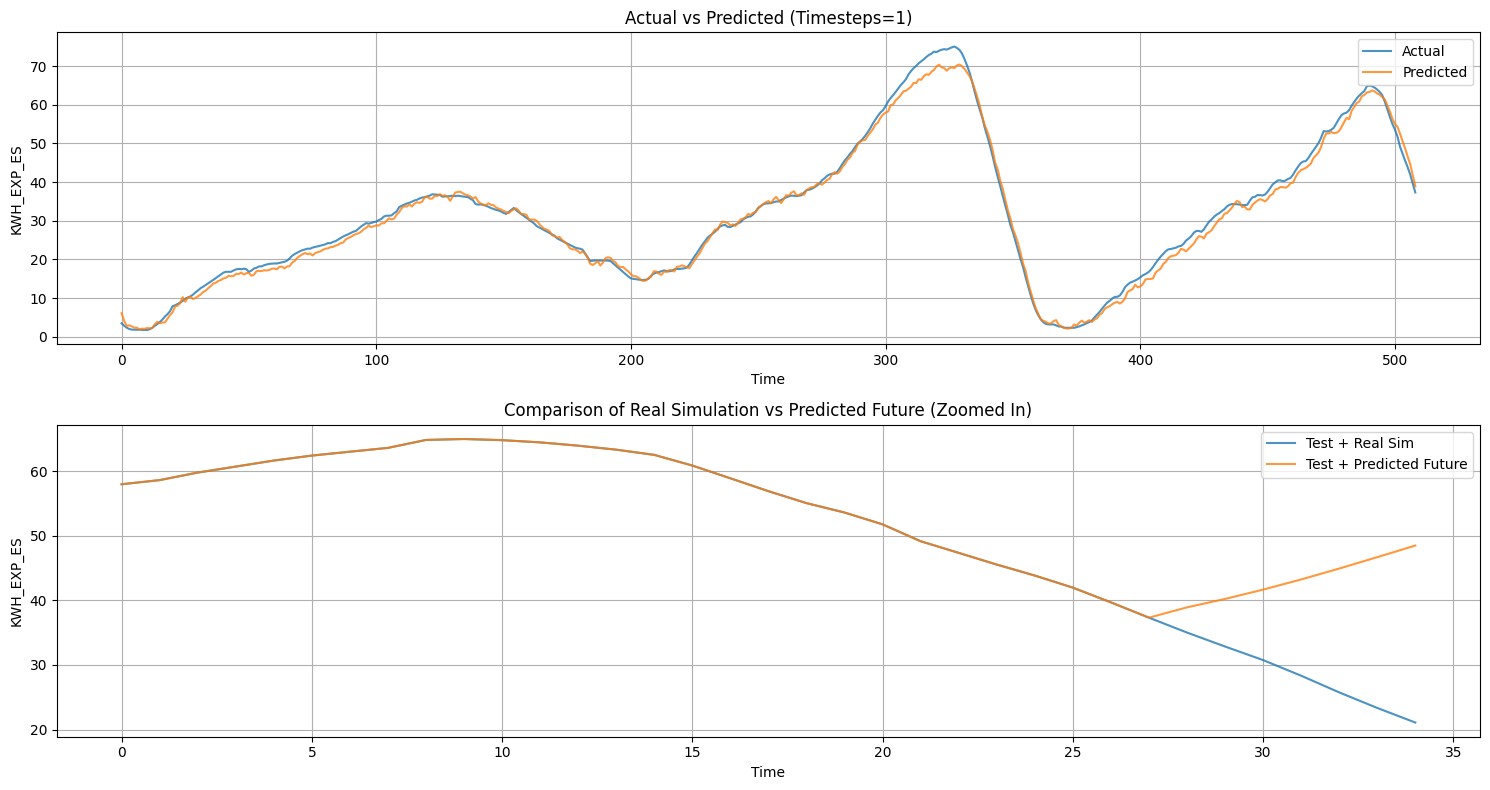


Metrics for timesteps=1:
MSE: 2.5088
R²: 0.9923
MAPE: 0.0580
MAE: 1.2298
Training time for timesteps = 1: 9.75 seconds

Training model with selected features and timesteps = 2
Selected features: Index(['tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR',
       'ss', 'KWH_EXP_MA', 'trend_ma', 'cycle_ma'],
      dtype='object')
Epoch 21: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Results saved to bilstm_timestep_2_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


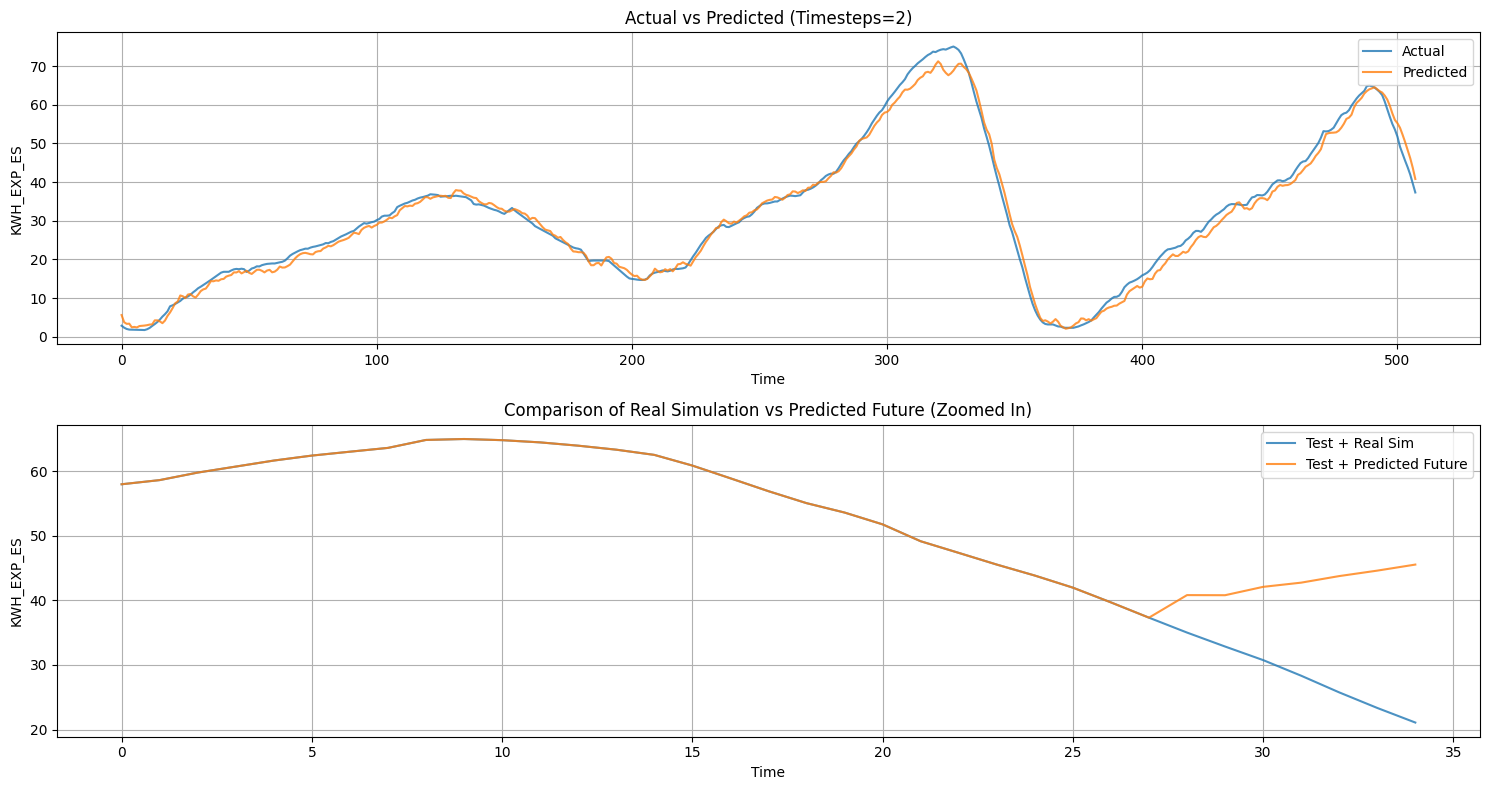


Metrics for timesteps=2:
MSE: 3.4701
R²: 0.9893
MAPE: 0.0765
MAE: 1.4710
Training time for timesteps = 2: 8.72 seconds

Training model with selected features and timesteps = 3
Selected features: Index(['tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR',
       'ss', 'KWH_EXP_MA', 'trend_ma', 'cycle_ma'],
      dtype='object')
Epoch 18: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Results saved to bilstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


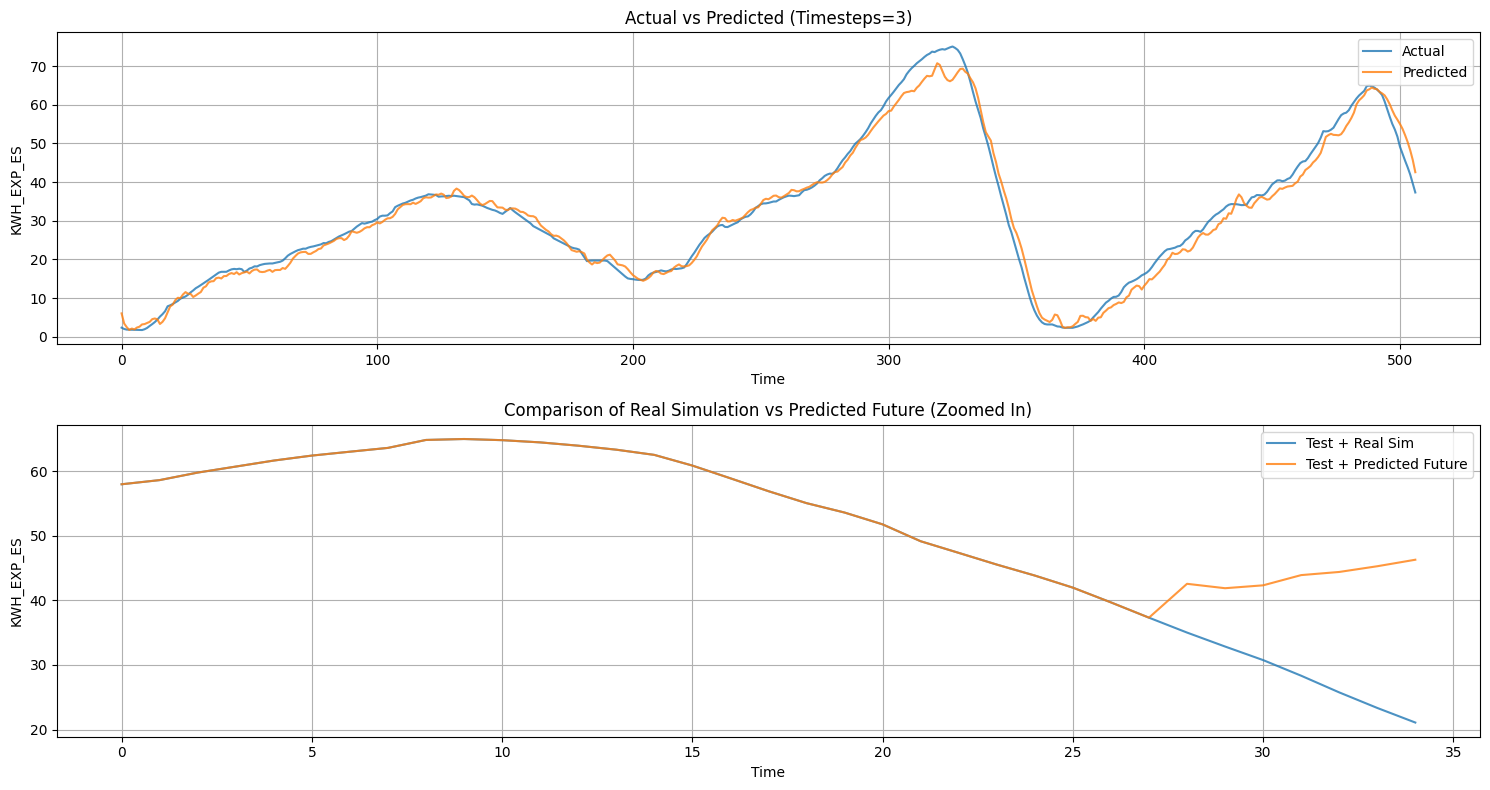


Metrics for timesteps=3:
MSE: 5.6532
R²: 0.9826
MAPE: 0.0927
MAE: 1.8176
Training time for timesteps = 3: 7.68 seconds

Training model with selected features and timesteps = 4
Selected features: Index(['tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR',
       'ss', 'KWH_EXP_MA', 'trend_ma', 'cycle_ma'],
      dtype='object')
Epoch 16: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Results saved to bilstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


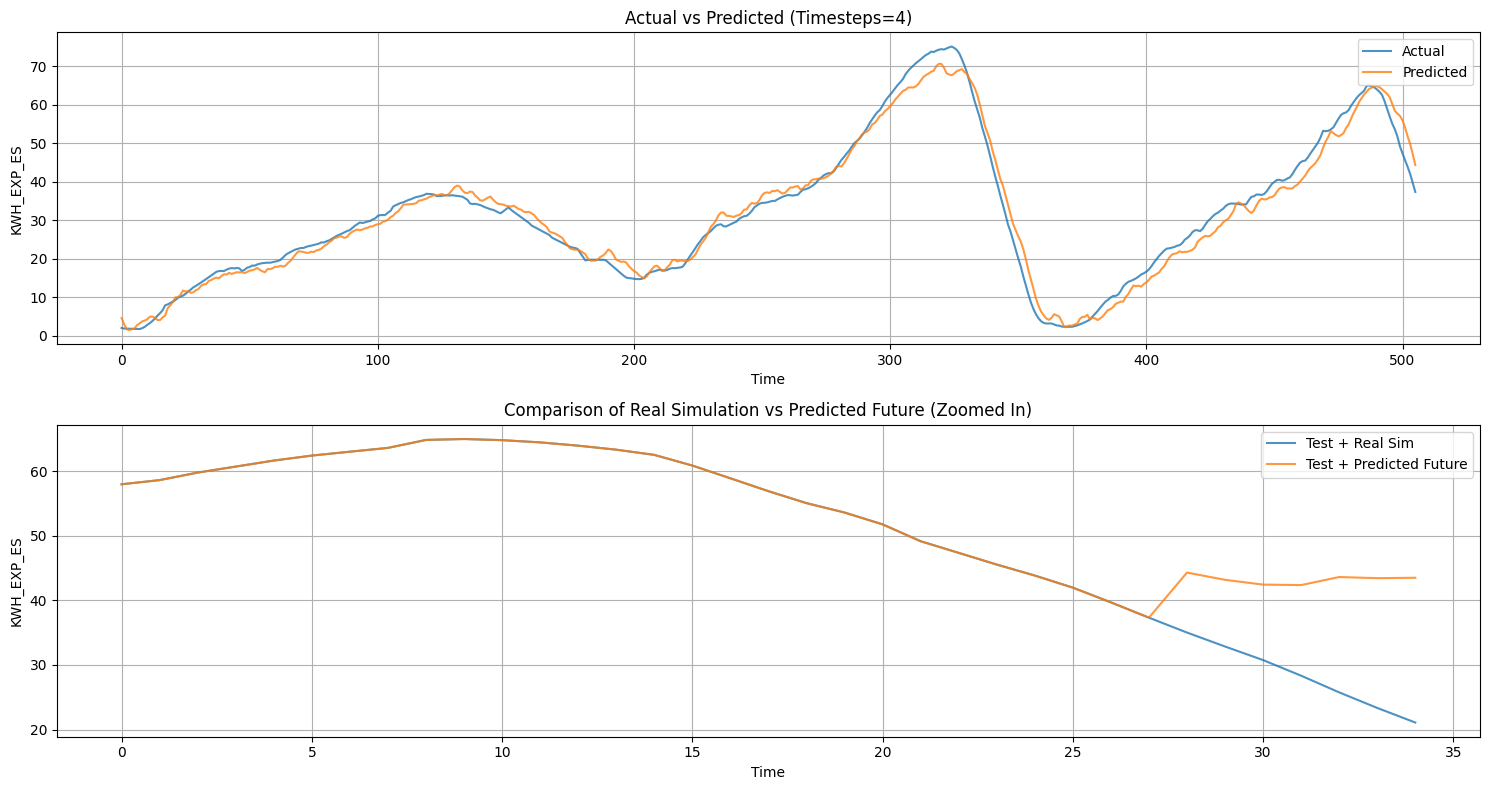


Metrics for timesteps=4:
MSE: 7.4226
R²: 0.9771
MAPE: 0.1096
MAE: 2.1810
Training time for timesteps = 4: 8.08 seconds

Training model with selected features and timesteps = 5
Selected features: Index(['tmin', 'wdir', 'RH_avg', 'RR', 'ss', 'KWH_EXP_MA', 'trend_ma',
       'cycle_ma'],
      dtype='object')
Epoch 10: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Results saved to bilstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


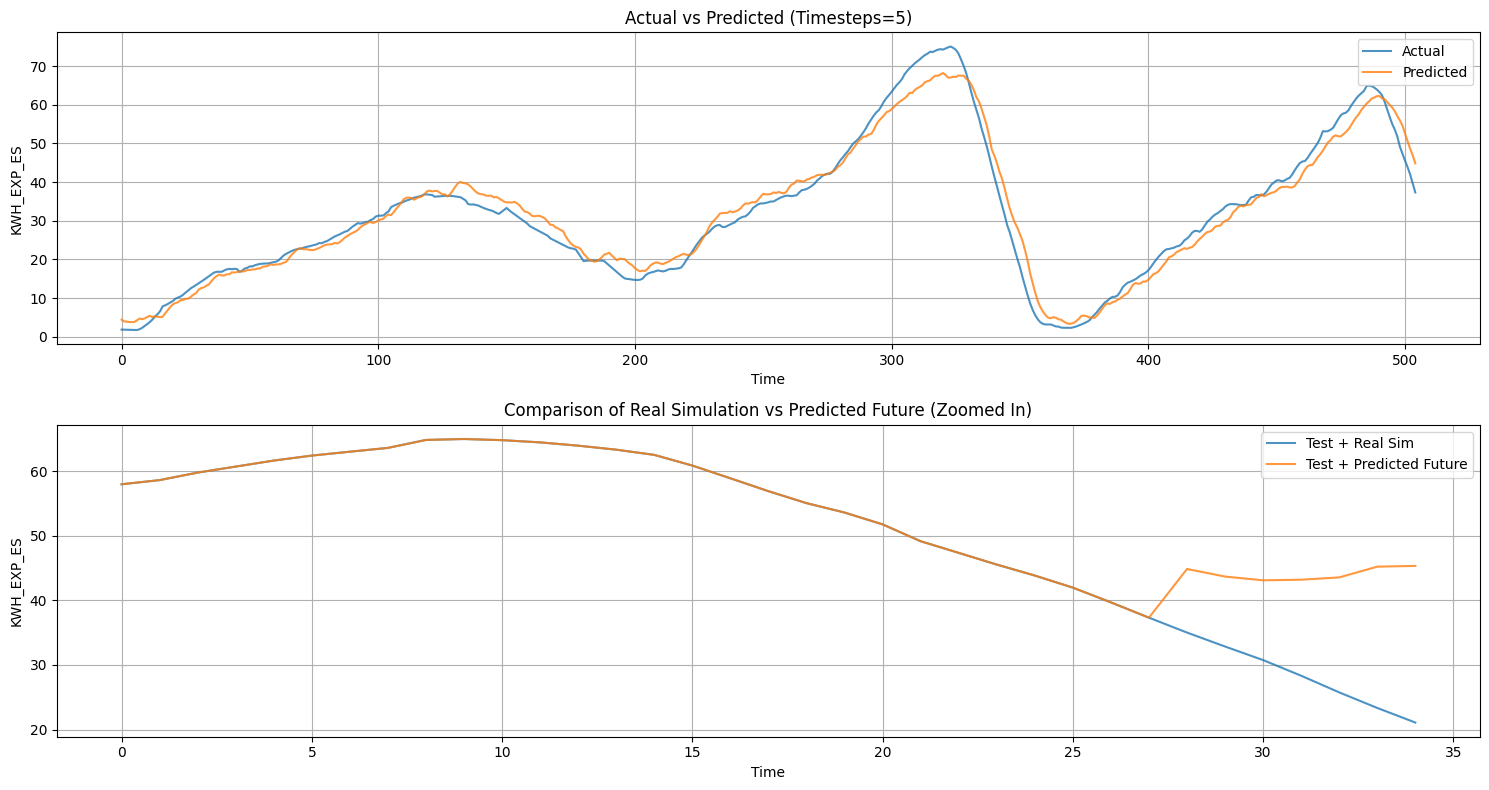


Metrics for timesteps=5:
MSE: 10.2296
R²: 0.9683
MAPE: 0.1404
MAE: 2.5682
Training time for timesteps = 5: 7.84 seconds

Training model with selected features and timesteps = 6
Selected features: Index(['tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR',
       'KWH_EXP_MA', 'cycle_ma'],
      dtype='object')
Epoch 14: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Results saved to bilstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


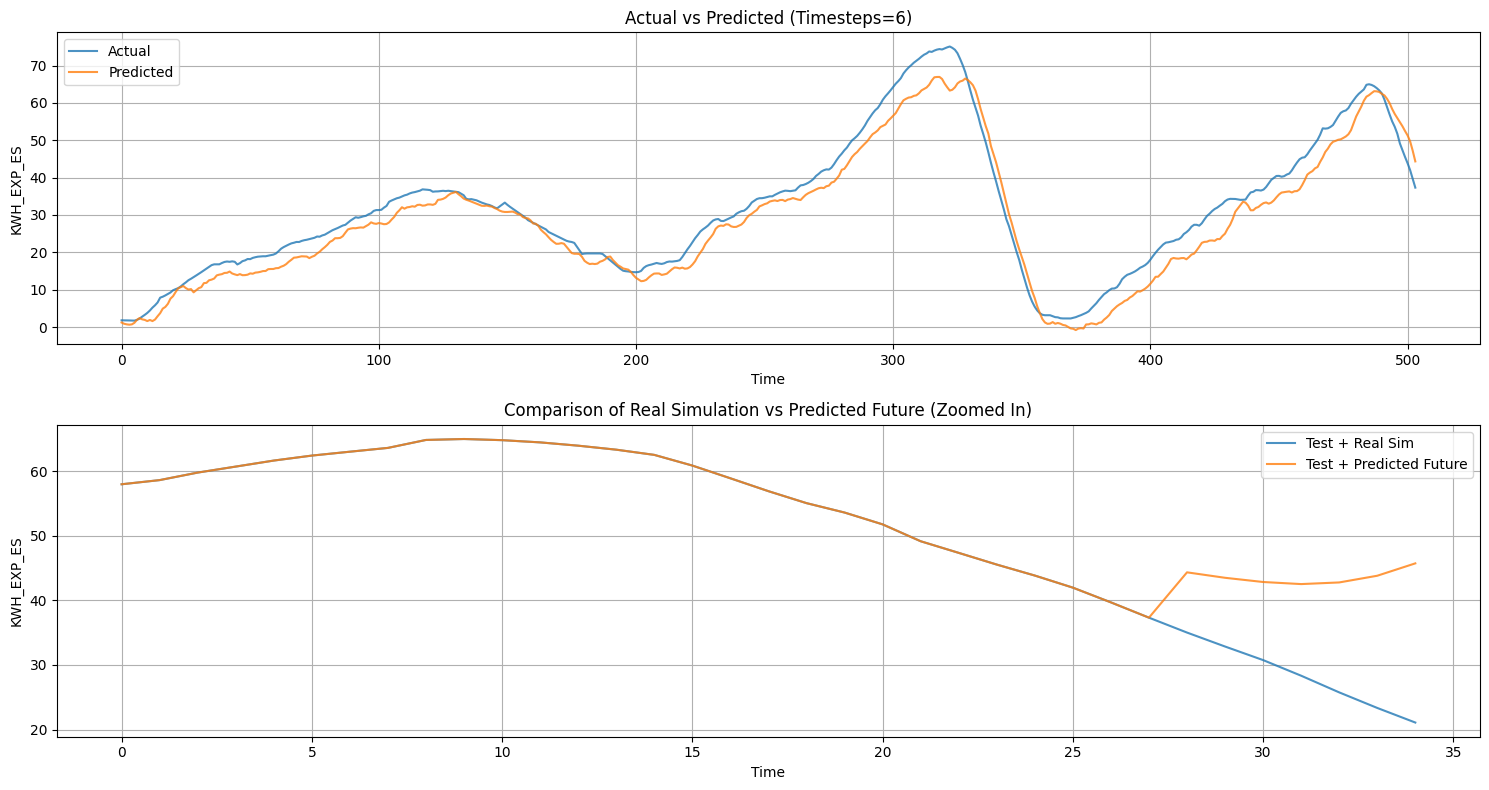


Metrics for timesteps=6:
MSE: 19.9719
R²: 0.9379
MAPE: 0.1830
MAE: 3.8306
Training time for timesteps = 6: 7.41 seconds

Training model with selected features and timesteps = 7
Selected features: Index(['tmin', 'tmax', 'Tavg', 'KWH_EXP_MA'], dtype='object')
Epoch 18: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Results saved to bilstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


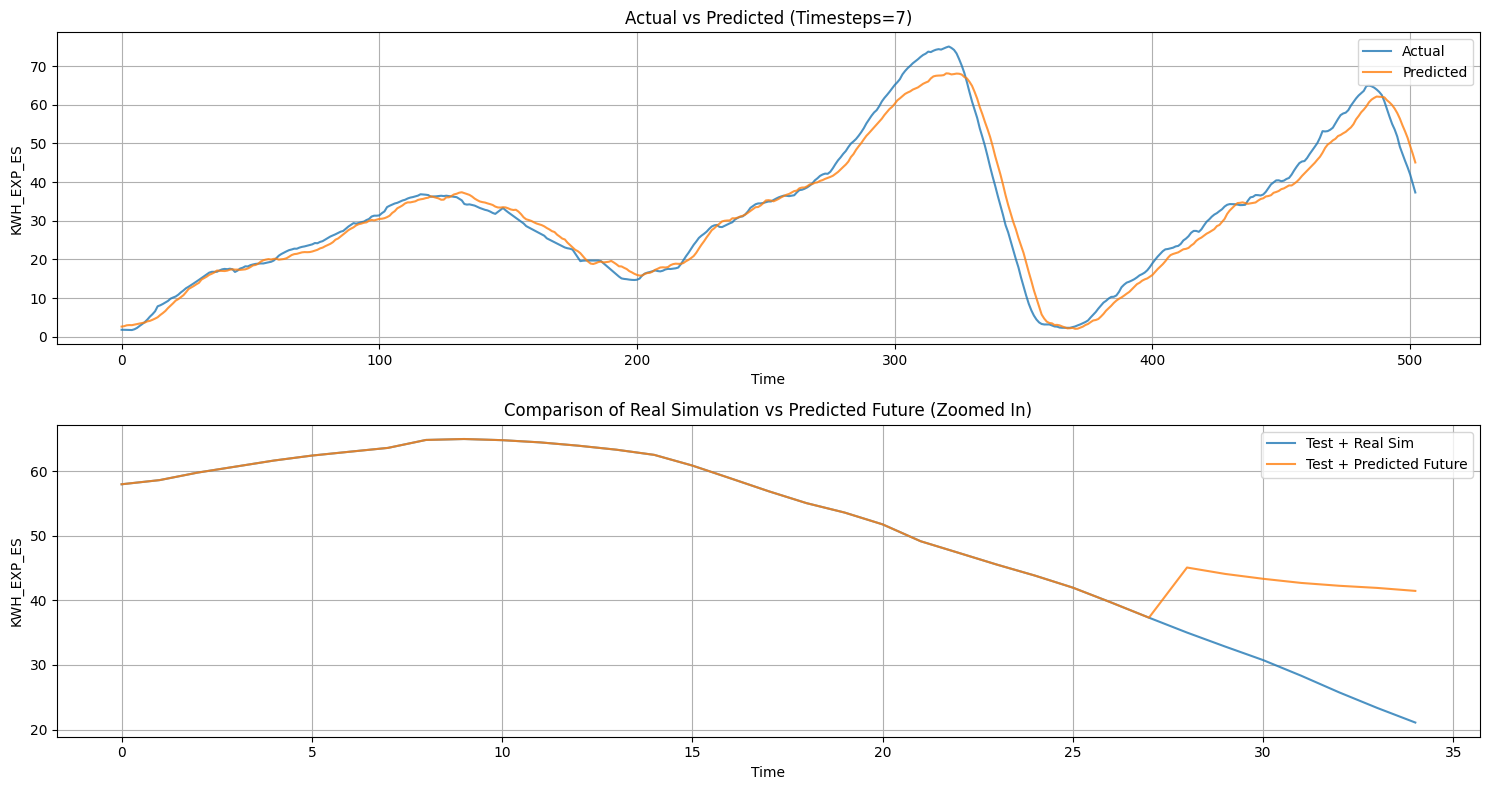


Metrics for timesteps=7:
MSE: 9.6921
R²: 0.9698
MAPE: 0.1033
MAE: 2.3204
Training time for timesteps = 7: 8.35 seconds
Total training execution time: 57.86 seconds


In [56]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    best_features = best_chromosomes_bilstm[ts]
    selected_features = [i for i in range(len(best_features)) if best_features[i] == 1]
    selected_feature_names = train.columns[selected_features]
    train_scaled_features_selected = train_scaled_features[:, selected_features]
    test_scaled_features_selected = test_scaled_features[:, selected_features]

    print(f"\nTraining model with selected features and timesteps = {ts}")
    print(f"Selected features: {selected_feature_names}")
    training_start_time = time.time()
    train_and_plot_bilstm(train_scaled_features_selected, train_scaled_target.ravel(), test_scaled_features_selected, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [57]:
# Fungsi untuk membuat model LSTM atau BiLSTM
def create_model(input_shape, model_type='lstm'):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if model_type == 'bilstm':
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Bidirectional(LSTM(64)))
    else:
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Fungsi untuk membuat dataset dengan timestep
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Fungsi untuk evaluasi kromosom
def evaluate_chromosome(chromosome, X_train, y_train, X_test, y_test, timesteps, model_type='lstm'):
    selected_features = [i for i in range(len(chromosome)) if chromosome[i] == 1]
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    X_train_t, y_train_t = create_dataset(X_train_selected, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test_selected, y_test, timesteps)

    model = create_model((X_train_t.shape[1], X_train_t.shape[2]), model_type)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

    model.fit(X_train_t, y_train_t, epochs=10, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    y_pred = model.predict(X_test_t)
    mse = mean_squared_error(y_test_t, y_pred)
    mae = mean_absolute_error(y_test_t, y_pred)
    r2 = r2_score(y_test_t, y_pred)
    mape = mean_absolute_percentage_error(y_test_t, y_pred)

    print(f"Evaluating chromosome {chromosome} -> MSE: {mse}, MAE: {mae}, R²: {r2}, MAPE: {mape}")
    return mse

# Fungsi untuk inisialisasi populasi
def initialize_population(pop_size, num_features):
    population = [np.random.randint(2, size=num_features) for _ in range(pop_size - 1)]
    # Tambahkan satu kromosom yang memiliki semua fitur diaktifkan
    population.append(np.ones(num_features, dtype=int))
    print(f"Initialized population: {population}")
    return population

# Fungsi untuk seleksi
def select(population, fitnesses, num_parents):
    indices = np.argsort(fitnesses)[:num_parents]
    parents = [population[i] for i in indices]
    print(f"Selected parents: {parents}")
    return parents

# Fungsi untuk crossover
def crossover(parents, offspring_size):
    offspring = []
    for _ in range(offspring_size):
        parent1, parent2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, len(parent1)-1)
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring.append(child)
        print(f"Crossover between {parent1} and {parent2} at {crossover_point} -> {child}")
    return offspring

# Fungsi untuk mutasi
def mutate(offspring, mutation_rate):
    for child in offspring:
        if random.random() < mutation_rate:
            mutation_point = random.randint(0, len(child)-1)
            child[mutation_point] = 1 - child[mutation_point]
            print(f"Mutated child {child} at {mutation_point}")
    return offspring

# Main GA function
def genetic_algorithm(X, y, timesteps_list, pop_size=5, num_generations=3, mutation_rate=0.1):
    num_features = X.shape[1]
    best_chromosomes = {}
    total_start_time = time.time()

    for timesteps in timesteps_list:
        print(f"\nRunning GA for feature selection with timesteps = {timesteps}")
        population = initialize_population(pop_size, num_features)
        start_time = time.time()

        for generation in range(num_generations):
            generation_start_time = time.time()
            fitnesses = np.array([evaluate_chromosome(chrom, X, y, X, y, timesteps) for chrom in population])
            best_fitness = np.min(fitnesses)
            best_chromosome = population[np.argmin(fitnesses)]

            parents = select(population, fitnesses, pop_size//2)
            offspring = crossover(parents, pop_size - len(parents))
            offspring = mutate(offspring, mutation_rate)
            population = np.concatenate((parents, offspring))

            generation_end_time = time.time()
            print(f"Generation {generation}: Best Fitness = {best_fitness}")
            print(f"Best Chromosome: {best_chromosome}")
            print(f"Population: {population}")
            print(f"Execution time for generation {generation}: {generation_end_time - generation_start_time:.2f} seconds")

        end_time = time.time()
        best_chromosomes[timesteps] = best_chromosome
        print(f"Best Features for timesteps = {timesteps}: {best_chromosome}")
        print(f"Execution time for timesteps {timesteps}: {end_time - start_time:.2f} seconds")

    total_end_time = time.time()
    print(f"Total execution time for GA: {total_end_time - total_start_time:.2f} seconds")

    return best_chromosomes

In [58]:
def train_and_plot_lstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="lstm", real_sim=real_sim, n_future=7)


In [59]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 2, 3, 4, 5, 6, 7]  # 1 hari, 3 hari, 1 minggu

# Run GA for feature selection for each timestep
best_chromosomes_lstm = genetic_algorithm(train_scaled_features, train_scaled_target.ravel(), timesteps_list)


Running GA for feature selection with timesteps = 1
Initialized population: [array([0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1]), array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]), array([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1]), array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluating chromosome [0 0 0 0 0 1 1 1 0 1 0 0 1] -> MSE: 0.01699765553102056, MAE: 0.10597080727006009, R²: 0.9830051474391464, MAPE: 0.5764849340551104
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluating chromosome [0 1 0 0 0 0 0 0 0 0 0 1 1] -> MSE: 0.0021137985505026687, MAE: 0.036267372642925066, R²: 0.9978865500219382, MAPE: 0.21385665400193335
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluating chromosome [0 1 1 0 1 0 1 0 1 1 0 0 1] -> MSE: 0.019149878661425382, MAE: 0.11185371987749385, R²: 0.9808532792175239, MAPE: 0.6713801893899117
Epoch 7: early stopping
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluating chromosome [0 0 1 0 0 0 


Training model with selected features and timesteps = 1
Selected features: Index(['tmin', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR', 'ss',
       'KWH_EXP_MA', 'trend_ma', 'cycle_ma'],
      dtype='object')
Epoch 48: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Results saved to lstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


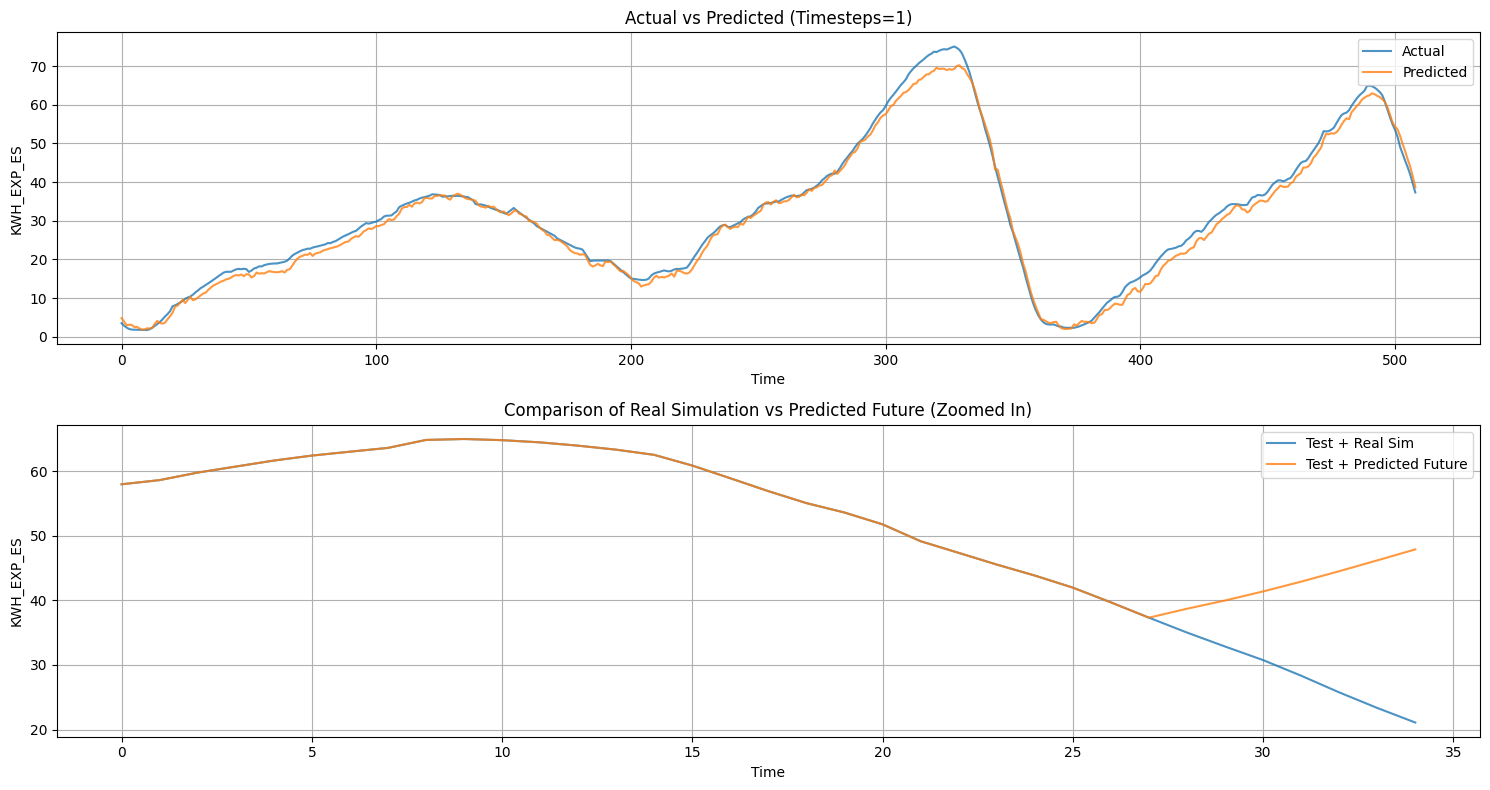


Metrics for timesteps=1:
MSE: 3.3005
R²: 0.9899
MAPE: 0.0701
MAE: 1.4540
Training time for timesteps = 1: 9.83 seconds

Training model with selected features and timesteps = 2
Selected features: Index(['tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR',
       'ss', 'KWH_EXP_MA', 'trend_ma', 'cycle_ma'],
      dtype='object')
Epoch 34: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_2_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


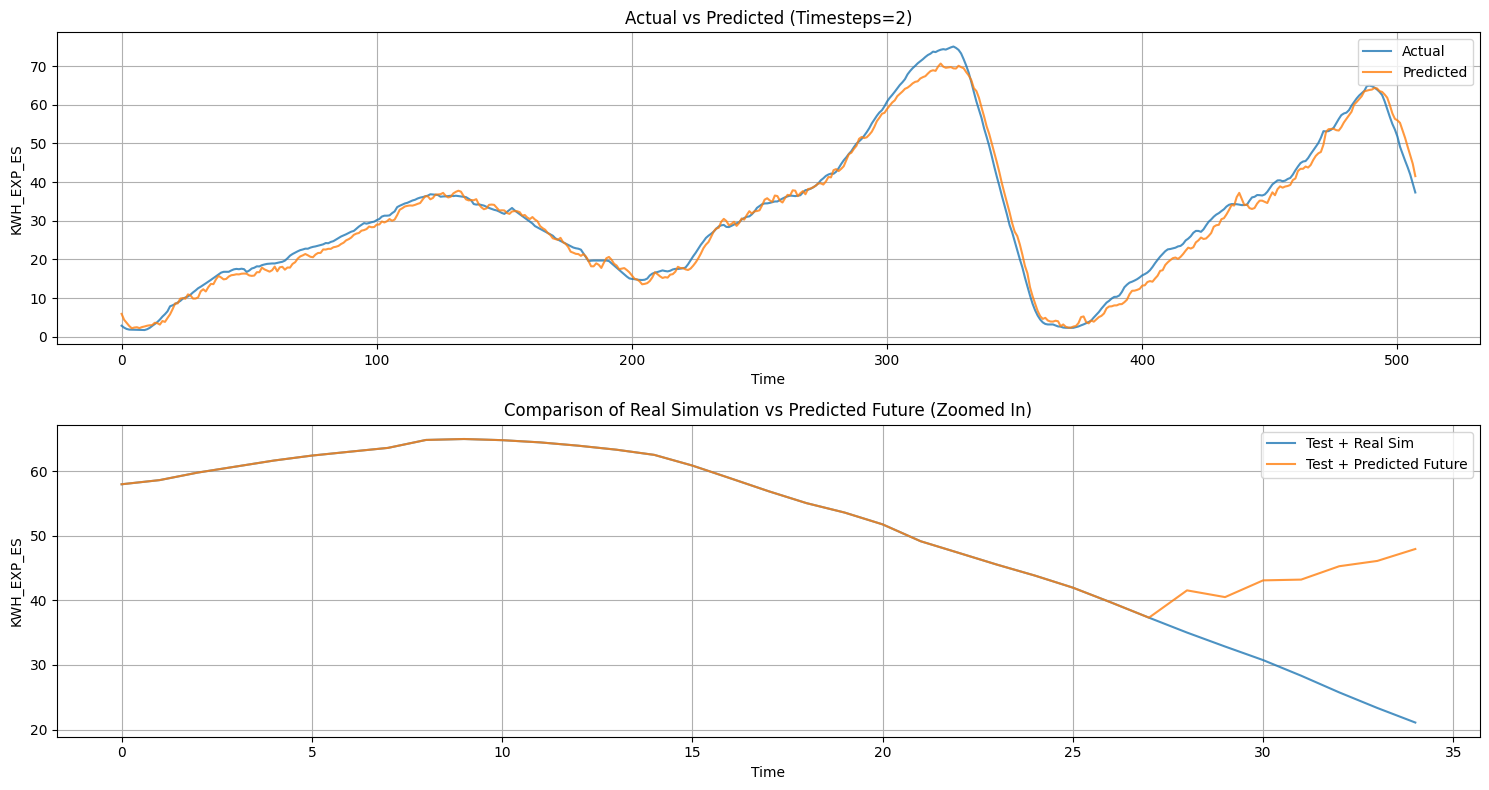


Metrics for timesteps=2:
MSE: 4.1601
R²: 0.9872
MAPE: 0.0834
MAE: 1.6240
Training time for timesteps = 2: 6.85 seconds

Training model with selected features and timesteps = 3
Selected features: Index(['tmin', 'wdir', 'wspd', 'Tavg', 'RH_avg', 'RR', 'ss', 'KWH_EXP_MA',
       'trend_ma', 'cycle_ma'],
      dtype='object')
Epoch 23: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


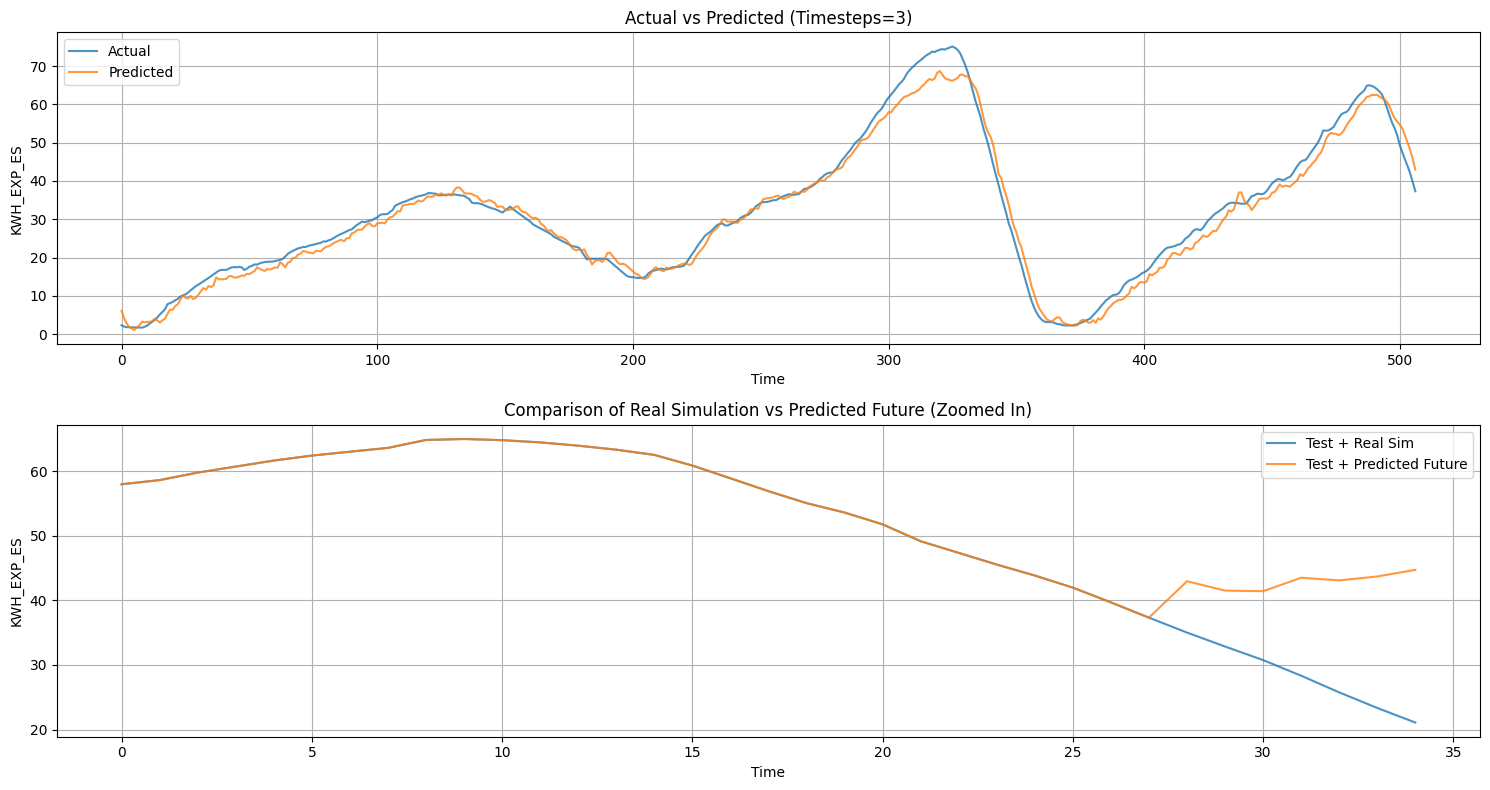


Metrics for timesteps=3:
MSE: 7.1531
R²: 0.9780
MAPE: 0.0996
MAE: 2.1002
Training time for timesteps = 3: 7.09 seconds

Training model with selected features and timesteps = 4
Selected features: Index(['tmin', 'pres', 'Tavg', 'RH_avg', 'RR', 'ss', 'KWH_EXP_MA', 'trend_ma',
       'cycle_ma'],
      dtype='object')
Epoch 20: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Results saved to lstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


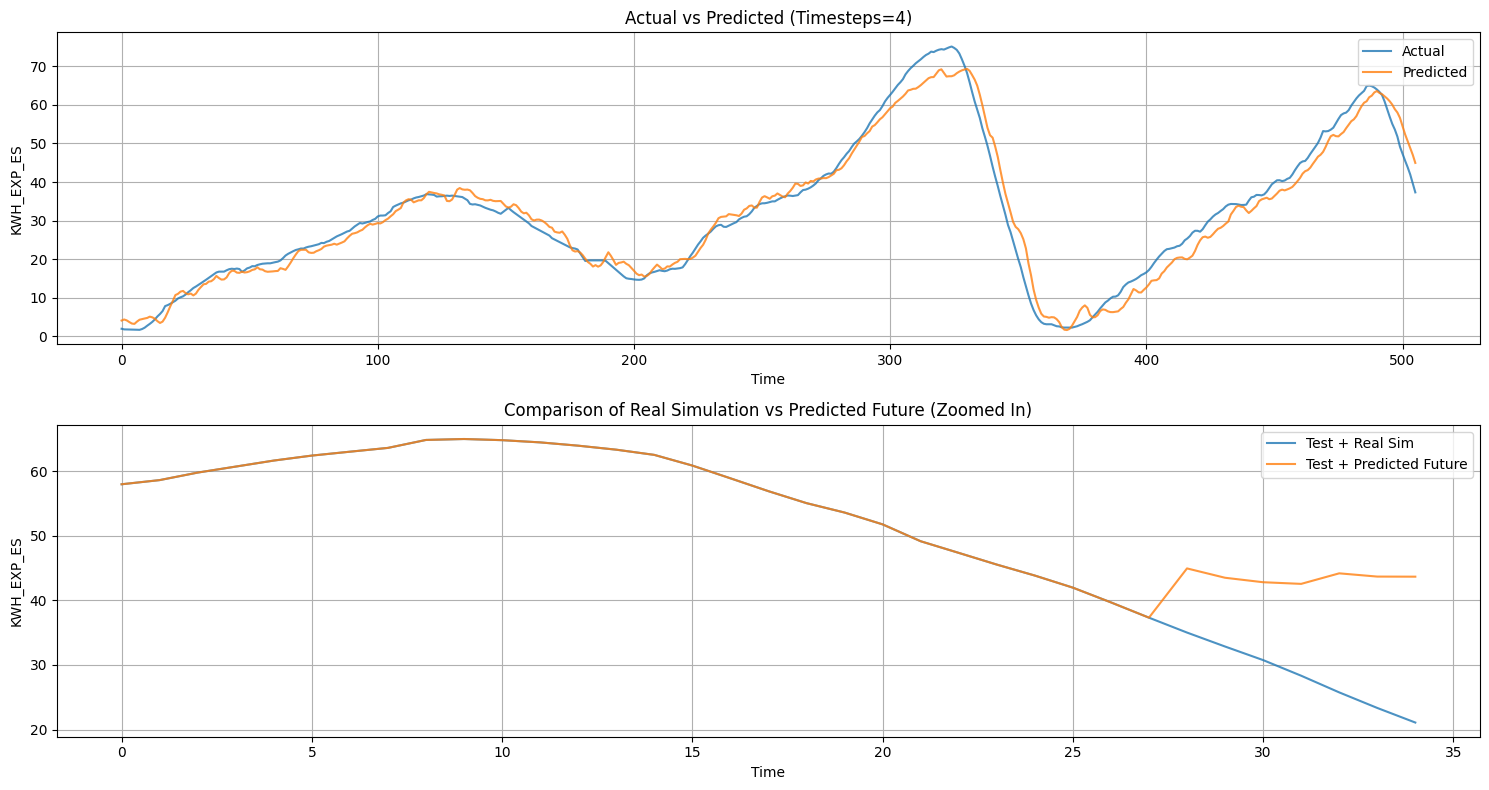


Metrics for timesteps=4:
MSE: 10.0093
R²: 0.9691
MAPE: 0.1416
MAE: 2.5341
Training time for timesteps = 4: 6.75 seconds

Training model with selected features and timesteps = 5
Selected features: Index(['wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR', 'ss', 'KWH_EXP_MA',
       'trend_ma', 'cycle_ma'],
      dtype='object')
Epoch 12: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Results saved to lstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


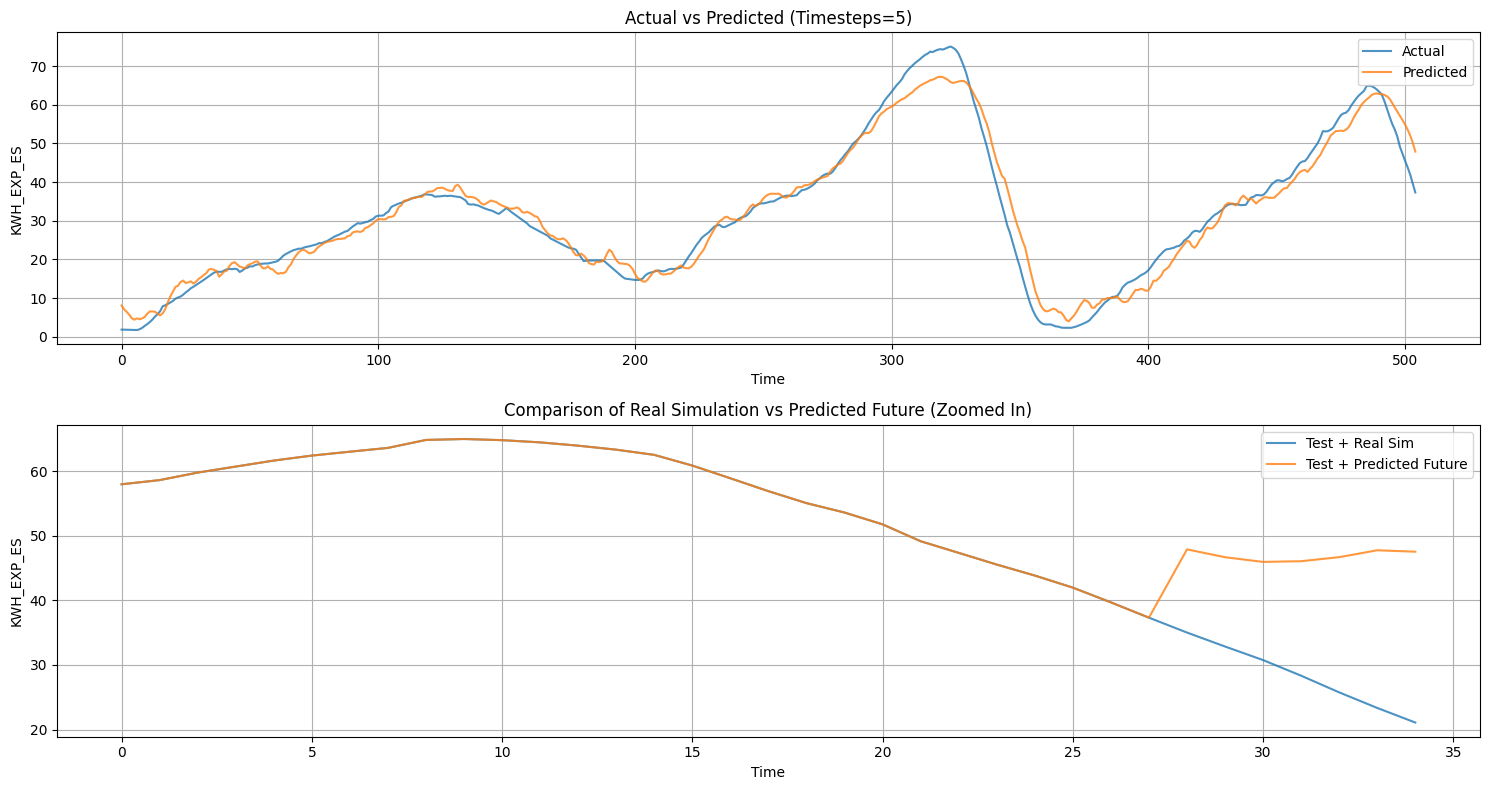


Metrics for timesteps=5:
MSE: 11.7972
R²: 0.9635
MAPE: 0.1840
MAE: 2.5730
Training time for timesteps = 5: 6.02 seconds

Training model with selected features and timesteps = 6
Selected features: Index(['wdir', 'Tavg', 'RH_avg', 'KWH_EXP_MA', 'trend_ma'], dtype='object')
Epoch 8: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Results saved to lstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


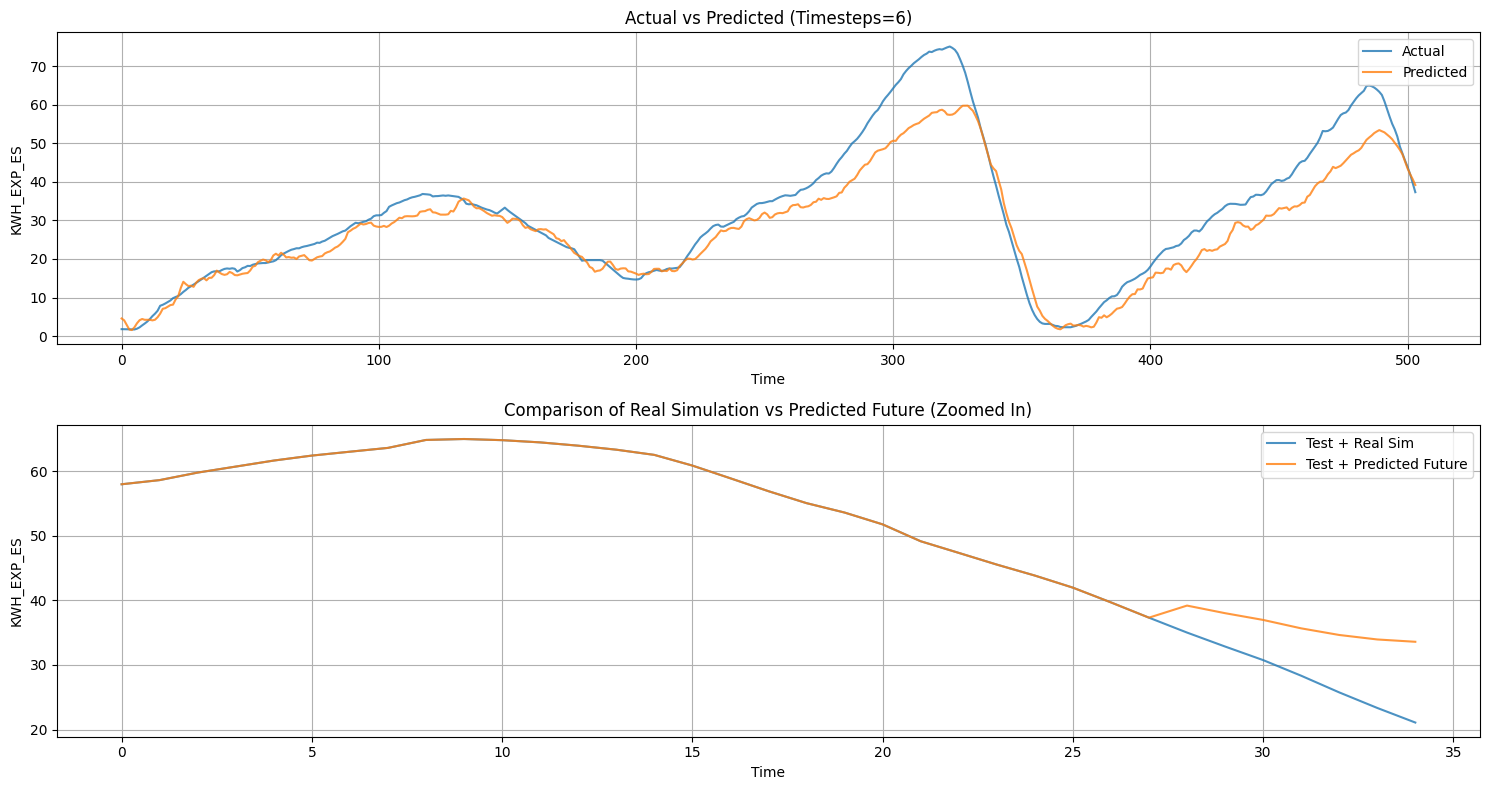


Metrics for timesteps=6:
MSE: 39.5919
R²: 0.8769
MAPE: 0.1555
MAE: 4.5200
Training time for timesteps = 6: 4.21 seconds

Training model with selected features and timesteps = 7
Selected features: Index(['tavg', 'tmax', 'KWH_EXP_MA'], dtype='object')
Epoch 8: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Results saved to lstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


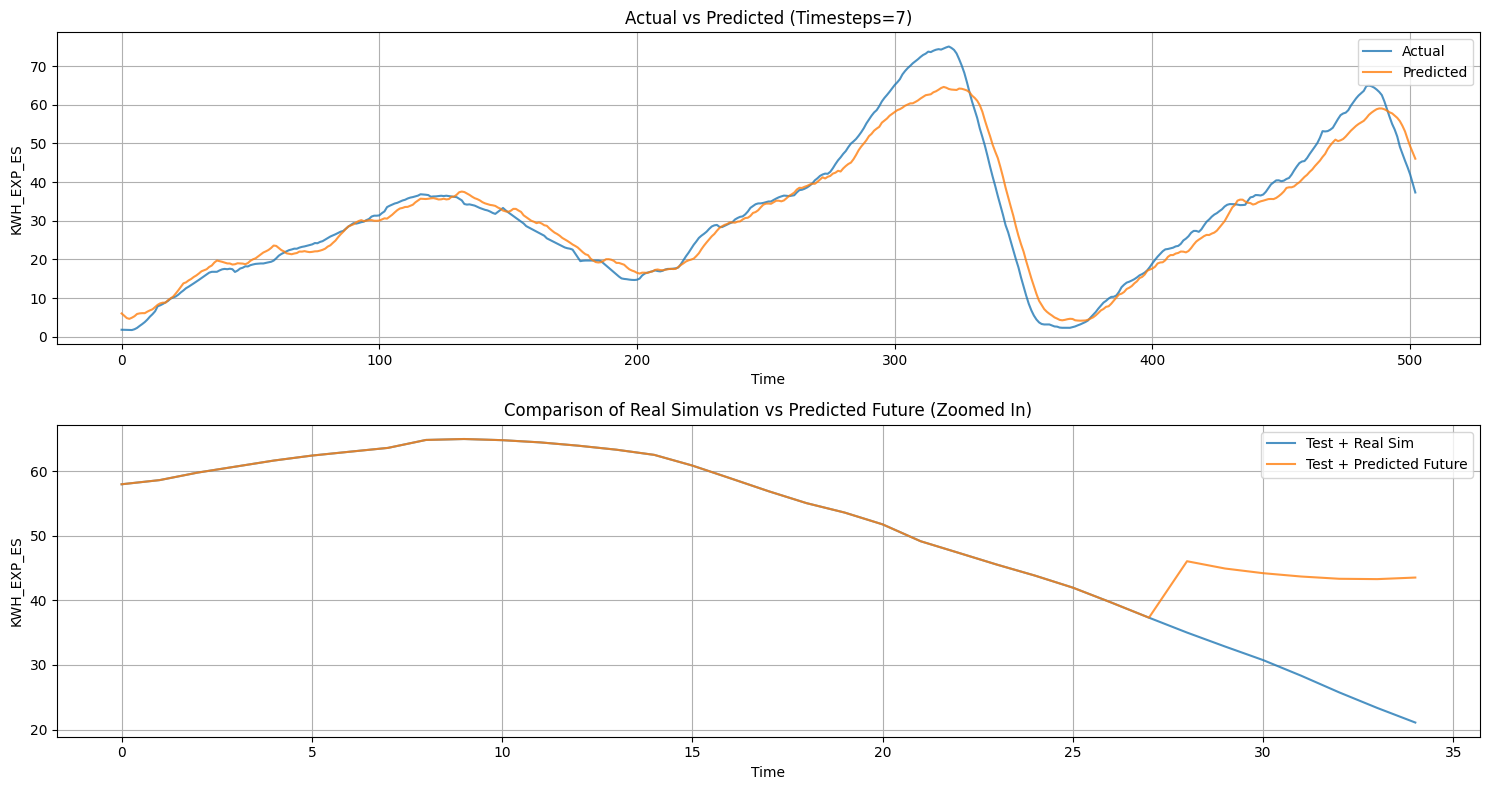


Metrics for timesteps=7:
MSE: 15.7596
R²: 0.9509
MAPE: 0.1561
MAE: 2.9240
Training time for timesteps = 7: 5.16 seconds
Total training execution time: 45.93 seconds


In [60]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    best_features = best_chromosomes_lstm[ts]
    selected_features = [i for i in range(len(best_features)) if best_features[i] == 1]
    selected_feature_names = train.columns[selected_features]
    train_scaled_features_selected = train_scaled_features[:, selected_features]
    test_scaled_features_selected = test_scaled_features[:, selected_features]

    print(f"\nTraining model with selected features and timesteps = {ts}")
    print(f"Selected features: {selected_feature_names}")
    training_start_time = time.time()
    train_and_plot_lstm(train_scaled_features_selected, train_scaled_target.ravel(), test_scaled_features_selected, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [61]:
# not zoom in
"""
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=48):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

        # Print metrics
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(combined_actual)), combined_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(combined_predicted)), combined_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
  """

'\ndef plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=48):\n    # Make predictions\n    y_pred = model.predict(X_test_t)\n    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))\n    y_pred_orig = target_scaler.inverse_transform(y_pred)\n\n    # Create DataFrame for Actual vs Predicted\n    results_df = pd.DataFrame({\n        \'Actual\': y_test_orig.flatten(),\n        \'Predicted\': y_pred_orig.flatten()\n    })\n\n    # Save DataFrame to CSV with model name and timesteps\n    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"\n    results_df.to_csv(file_name, index=False)\n    print(f"Results saved to {file_name}")\n\n    # Plot Actual vs Predicted\n    plt.figure(figsize=(15, 8))\n    plt.subplot(2, 1, 1)\n    plt.plot(results_df[\'Actual\'], label=\'Actual\', alpha=0.8)\n    plt.plot(results_df[\'Predicted\'], label=\'Predicted\', alpha=0.8)\n    plt.title(f\'Actual vs Predicted (Timesteps={timestep